In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_path = "/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_Diease/Rice_Leaf_Diease/train"
images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.head(10)

,image,label
0,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
1,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
2,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
3,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
4,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
5,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
6,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
7,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
8,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast
9,/kaggle/input/rice-leaf-diseases-detection/Ric...,neck_blast


In [4]:
data.shape

(15023, 2)

In [5]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 12018 validated image filenames belonging to 10 classes.
Found 1502 validated image filenames belonging to 10 classes.
Found 1503 validated image filenames belonging to 10 classes.


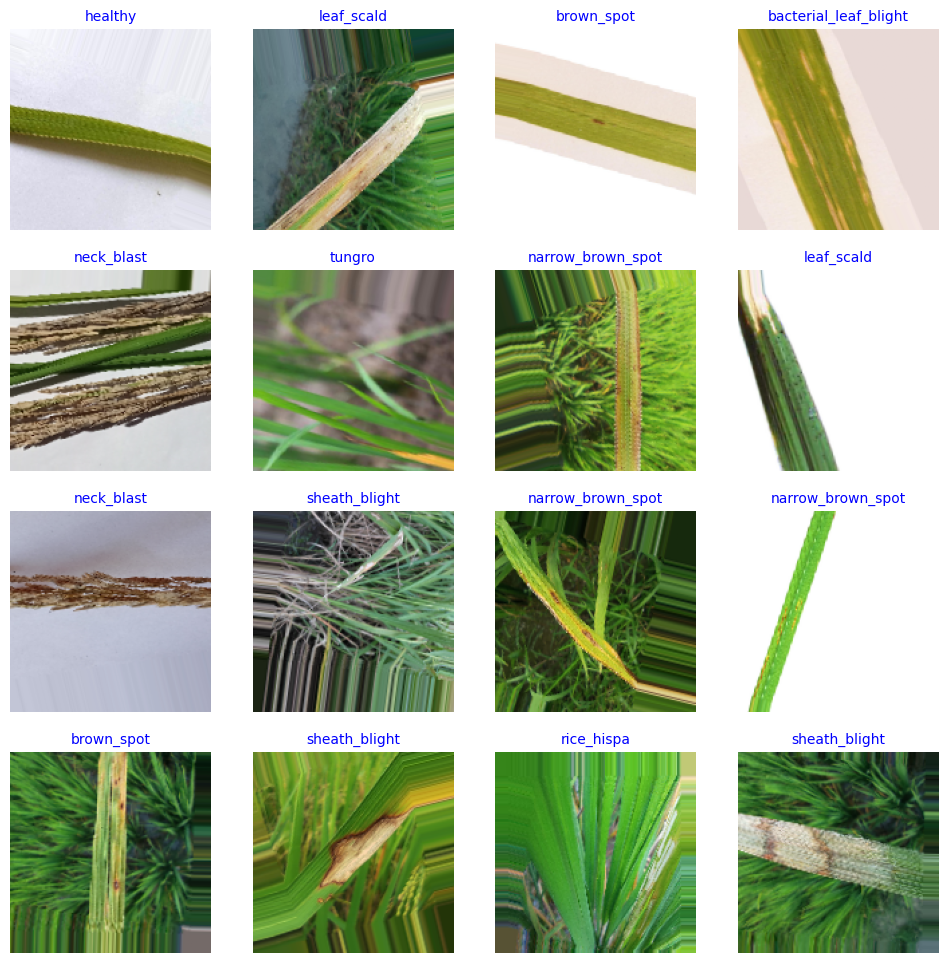

In [7]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [10]:
from tensorflow.keras.layers import BatchNormalization


n_classes = 10
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))



model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          65,6

 Total params: 1,049,450 (4.00 MB)

 Trainable params: 1,047,978 (4.00 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=3,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen
)

Epoch 1/3
376/376 - 257s - 685ms/step - accuracy: 0.7061 - loss: 1.9476 - val_accuracy: 0.6991 - val_loss: 1.8329
Epoch 2/3
376/376 - 223s - 593ms/step - accuracy: 0.7727 - loss: 1.4444 - val_accuracy: 0.5812 - val_loss: 2.2474
Epoch 3/3
376/376 - 217s - 577ms/step - accuracy: 0.7983 - loss: 1.1700 - val_accuracy: 0.7543 - val_loss: 1.2246


In [14]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 412ms/step - accuracy: 0.7550 - loss: 1.2301
Accuracy score: 0.7543275356292725


In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

167/167 ━━━━━━━━━━━━━━━━━━━━ 92s 547ms/step - accuracy: 0.7366 - loss: 1.2936
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.7545 - loss: 1.2262
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.7393 - loss: 1.2561 
Train Loss:  1.3058565855026245
Train Accuracy:  0.7294161915779114
--------------------
Valid Loss:  1.2246181964874268
Valid Accuracy:  0.7543275356292725
--------------------
Test Loss:  1.2572928667068481
Test Accuracy:  0.7371922731399536


In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step


In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.93      0.96       138
           brown_spot       0.54      0.79      0.64       148
              healthy       0.62      0.87      0.72       149
           leaf_blast       0.53      0.46      0.49       181
           leaf_scald       0.99      0.52      0.68       167
    narrow_brown_spot       0.61      0.58      0.59       142
           neck_blast       0.98      0.98      0.98       100
           rice_hispa       0.86      0.94      0.90       146
        sheath_blight       0.65      0.70      0.67       158
               tungro       0.99      0.78      0.87       174

             accuracy                           0.74      1503
            macro avg       0.78      0.75      0.75      1503
         weighted avg       0.77      0.74      0.74      1503



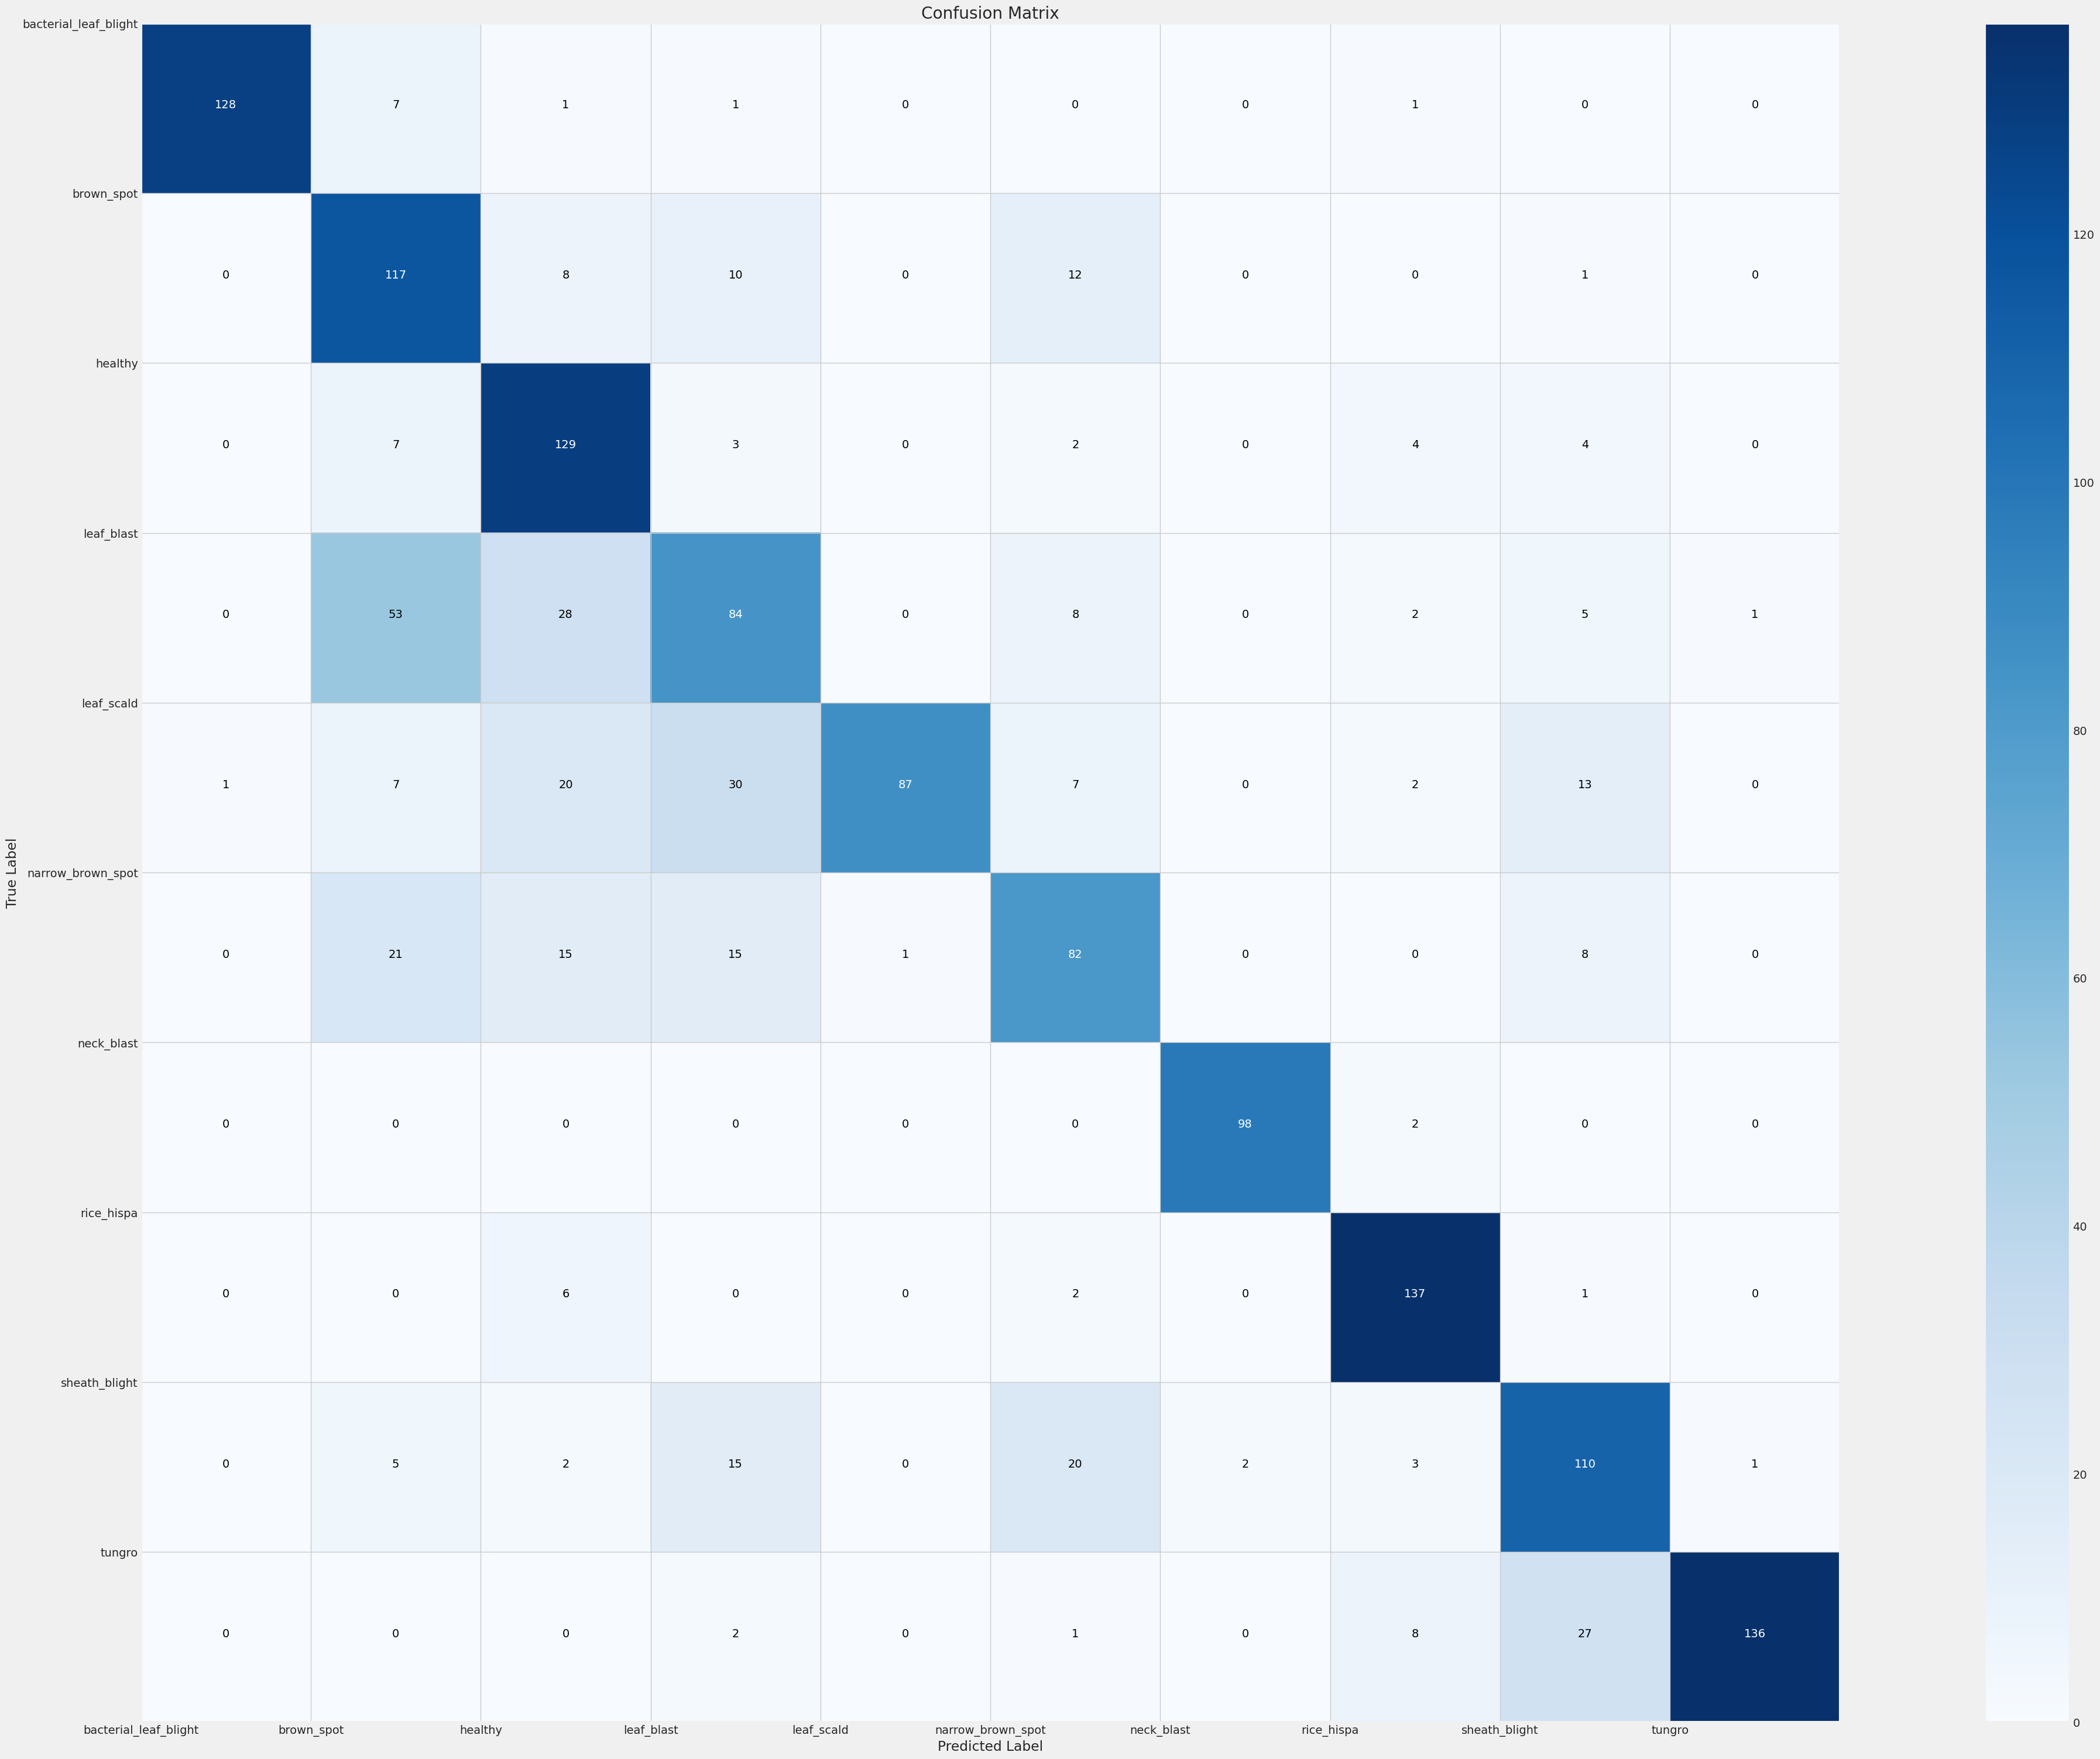

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (50, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step


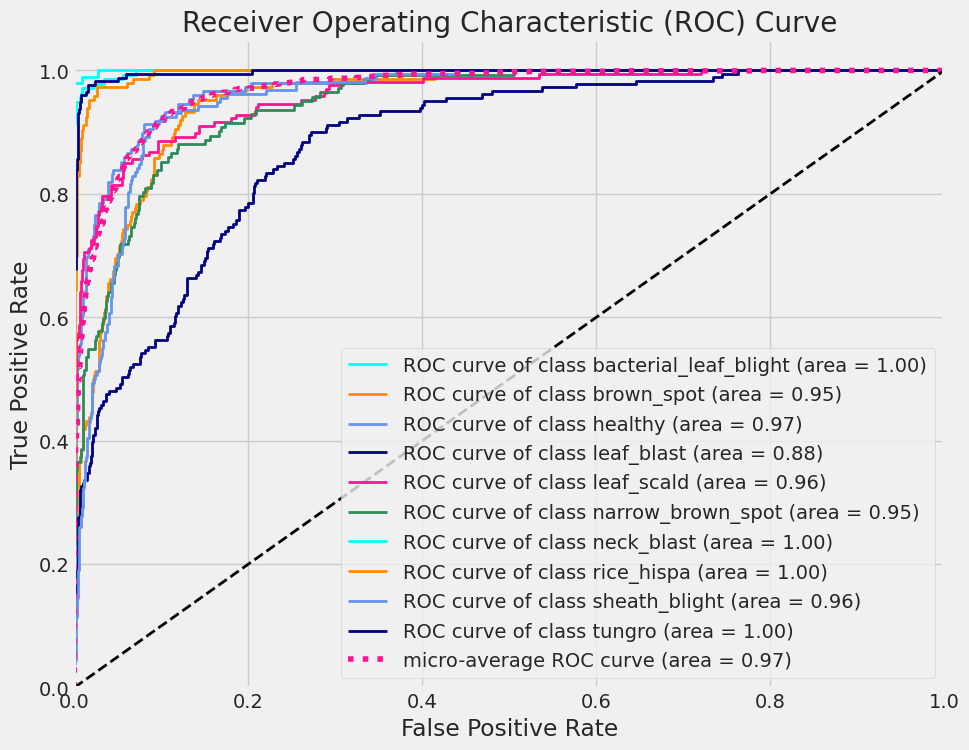

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class bacterial_leaf_blight: 1.00
AUC for class brown_spot: 0.95
AUC for class healthy: 0.97
AUC for class leaf_blast: 0.88
AUC for class leaf_scald: 0.96
AUC for class narrow_brown_spot: 0.95
AUC for class neck_blast: 1.00
AUC for class rice_hispa: 1.00
AUC for class sheath_blight: 0.96
AUC for class tungro: 1.00
Micro-average AUC: 0.97
Macro-average AUC: 0.97
